In [1]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics.pairwise import haversine_distances
from xgboost import XGBRegressor
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.sampling import Condition

### Pre-processing

In [2]:
claims_df = pd.read_csv("AFC_claims.csv")
# Dollars should be rounded to 2 decimals
claims_df["ClaimAmount"] = claims_df.ClaimAmount.round(2)
claims_df

,BusinessID,ClaimAmount
0,00006A45,277674.57
1,00007A94,139775.41
2,0002A104,376145.26
3,0003A113,86434.20
4,0005A152,218156.43
...,...,...
8668,3A249916,469764.04
8669,0A249934,60665.72
8670,0A249935,235096.44
8671,6A249979,187283.83


In [3]:
policies_df = pd.read_csv("AFC_policies.csv")
policies_df

,BusinessID,BusinessType,Province,Latitude,Longitude,City,AmountOfInsurance,Earnings
0,000002A1,photographic studios,ON,45.09,-79.45,BRACEBRIDGE,416800.0,98000.0
1,000000A2,massage therapists,QC,46.78,-71.26,QUEBEC,904600.0,406000.0
2,000004A3,lawyers offices,ON,46.52,-84.33,SAULT STE. MARIE,883300.0,157000.0
3,000005A4,optometrists offices,QC,45.56,-73.85,LAVAL,263400.0,86000.0
4,000001A5,chiropractors' offices,ON,43.14,-82.06,FOREST,706500.0,231000.0
...,...,...,...,...,...,...,...,...
249995,1A249996,photographic studios,QC,45.45,-73.81,POINTE-CLAIRE,440300.0,293000.0
249996,8A249997,automobile parking facilities,QC,45.44,-75.74,GATINEAU,661400.0,264000.0
249997,3A249998,arts and crafts stores,ON,43.22,-79.91,HAMILTON,443300.0,210000.0
249998,3A249999,yoga studios,ON,46.34,-79.47,NORTH BAY,780700.0,132000.0


In [4]:
# Merge Province and City into Address
policies_df["Address"] = policies_df.Province + "," + policies_df.City
policies_df = policies_df.drop(columns=["Province", "City"])

# Set numerical features
policies_df.AmountOfInsurance = policies_df.AmountOfInsurance.astype("int")
policies_df.Earnings = policies_df.Earnings.astype("int")

# Set categorical features
policies_df.BusinessType = policies_df.BusinessType.astype("category")
policies_df.Address = policies_df.Address.astype("category")

# Select necessary columns for training and perform label encoding on categorical columns
policies_df["BusinessTypeCode"] = policies_df.BusinessType.cat.codes
# Top 10 encoding, top 1 to 9 address codes are encoded 1 to 9, others are encoded 0
top_addresses = list(policies_df.Address.cat.codes.value_counts().nlargest(9).index)
top_addresses_dict = defaultdict(int)
for idx, code in enumerate(top_addresses):
    top_addresses_dict[code] = idx+1
policies_df["AddressCode"] = policies_df.Address.cat.codes.map(top_addresses_dict)
policies_df = policies_df.drop(columns=["BusinessType", "Address"])

# One hot encoding
business_codes = policies_df.BusinessTypeCode.copy()
policies_df = pd.get_dummies(policies_df, columns=["BusinessTypeCode"])
policies_df["BusinessTypeCode"] = business_codes

# One hot encoding
address_codes = policies_df.AddressCode.copy()
policies_df = pd.get_dummies(policies_df, columns=["AddressCode"])
policies_df["AddressCode"] = address_codes
policies_df.AddressCode = policies_df.AddressCode.astype(np.int8)

# Represent Earnings, AmountOfInsurance in 1000s of dollars, then take log to reduce skewness
policies_df.AmountOfInsurance /= 1000
policies_df.Earnings /= 1000
policies_df.AmountOfInsurance = np.log(policies_df.AmountOfInsurance)
policies_df.Earnings = np.log(policies_df.Earnings)

policies_df

,BusinessID,Latitude,Longitude,AmountOfInsurance,Earnings,BusinessTypeCode_0,BusinessTypeCode_1,BusinessTypeCode_2,BusinessTypeCode_3,BusinessTypeCode_4,...,AddressCode_1,AddressCode_2,AddressCode_3,AddressCode_4,AddressCode_5,AddressCode_6,AddressCode_7,AddressCode_8,AddressCode_9,AddressCode
0,000002A1,45.09,-79.45,6.032606,4.584967,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000000A2,46.78,-71.26,6.807493,6.006353,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
2,000004A3,46.52,-84.33,6.783665,5.056246,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000005A4,45.56,-73.85,5.573674,4.454347,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6
4,000001A5,43.14,-82.06,6.560323,5.442418,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,1A249996,45.45,-73.81,6.087456,5.680173,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249996,8A249997,45.44,-75.74,6.494359,5.575949,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
249997,3A249998,43.22,-79.91,6.094247,5.347108,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
249998,3A249999,46.34,-79.47,6.660191,4.882802,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Sanity check: There are no new businesses in claims data
a = set(policies_df.BusinessID)
b = set(claims_df.BusinessID)
print(b - a)
# Outer join to make consolidated table
train_consolidated_df = claims_df.merge(policies_df, on="BusinessID", how="outer")
train_consolidated_df

set()


,BusinessID,ClaimAmount,Latitude,Longitude,AmountOfInsurance,Earnings,BusinessTypeCode_0,BusinessTypeCode_1,BusinessTypeCode_2,BusinessTypeCode_3,...,AddressCode_1,AddressCode_2,AddressCode_3,AddressCode_4,AddressCode_5,AddressCode_6,AddressCode_7,AddressCode_8,AddressCode_9,AddressCode
0,00006A45,277674.57,43.90,-79.27,6.694067,4.682131,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00007A94,139775.41,43.65,-79.43,6.535532,5.147494,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
2,0002A104,376145.26,43.15,-80.24,6.778899,5.497168,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0003A113,86434.20,45.70,-73.63,6.139453,4.997212,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0005A152,218156.43,43.64,-79.76,6.919684,5.513429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250196,1A249996,NaN,45.45,-73.81,6.087456,5.680173,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250197,8A249997,NaN,45.44,-75.74,6.494359,5.575949,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
250198,3A249998,NaN,43.22,-79.91,6.094247,5.347108,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
250199,3A249999,NaN,46.34,-79.47,6.660191,4.882802,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Using ClaimAmount create NumClaims and ExpectedSeverity columns taking into account duplicate BusinessID rows
train_consolidated_df["DidClaim"] = train_consolidated_df.ClaimAmount > 0
# Treat number of claims as continuos variable
num_claims = train_consolidated_df.groupby("BusinessID").DidClaim.sum().astype(float)
num_claims.name = "NumClaims"
expected_severity = train_consolidated_df.groupby("BusinessID").ClaimAmount.mean()
expected_severity.name = "ExpectedSeverity"
train_consolidated_df = train_consolidated_df.merge(num_claims, on="BusinessID")
train_consolidated_df = train_consolidated_df.merge(expected_severity, on="BusinessID")

# Drop DidClaim, ClaimAmount column and remove duplicate rows
train_consolidated_df = train_consolidated_df.drop(columns=["DidClaim", "ClaimAmount"])
train_consolidated_df = train_consolidated_df.drop_duplicates("BusinessID")

# Represent ExpectedSeverity in 1000s of dollars, then take log to reduce skewness
train_consolidated_df.ExpectedSeverity /= 1000
train_consolidated_df.ExpectedSeverity = np.log(train_consolidated_df.ExpectedSeverity)

# Drop BusinessID
train_consolidated_df = train_consolidated_df.drop(columns=["BusinessID"])

train_consolidated_df

,Latitude,Longitude,AmountOfInsurance,Earnings,BusinessTypeCode_0,BusinessTypeCode_1,BusinessTypeCode_2,BusinessTypeCode_3,BusinessTypeCode_4,BusinessTypeCode_5,...,AddressCode_3,AddressCode_4,AddressCode_5,AddressCode_6,AddressCode_7,AddressCode_8,AddressCode_9,AddressCode,NumClaims,ExpectedSeverity
0,43.90,-79.27,6.694067,4.682131,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,5.626450
1,43.65,-79.43,6.535532,5.147494,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1.0,4.940037
2,43.15,-80.24,6.778899,5.497168,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,5.929975
3,45.70,-73.63,6.139453,4.997212,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,4.459383
4,43.64,-79.76,6.919684,5.513429,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,5.385212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250196,45.45,-73.81,6.087456,5.680173,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
250197,45.44,-75.74,6.494359,5.575949,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.0,NaN
250198,43.22,-79.91,6.094247,5.347108,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
250199,46.34,-79.47,6.660191,4.882802,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN


In [7]:
# # Use Latitude, Longitude to perform geo clustering
# # https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
# coords = train_consolidated_df[["Latitude", "Longitude"]].to_numpy()
# coords = np.radians(coords)
# kms_per_raidan = 6371.0088
# # max distance between points to be considered in a cluster
# epsilon = 100.0 / kms_per_raidan
# # Use great circle distance metric
# db = DBSCAN(eps=epsilon, min_samples=1, algorithm="ball_tree", metric="haversine").fit(coords)
# print(len(set(db.labels_)))
# train_consolidated_df["GeoClusterCode"] = db.labels_

# # One hot encoding of geo cluster
# geocluster_codes = train_consolidated_df.GeoClusterCode.copy()
# train_consolidated_df = pd.get_dummies(train_consolidated_df, columns=["GeoClusterCode"])
# train_consolidated_df["GeoClusterCode"] = geocluster_codes
# sns.scatterplot(train_consolidated_df, x="Longitude", y="Latitude", hue="GeoClusterCode", palette="turbo")

### Analysis

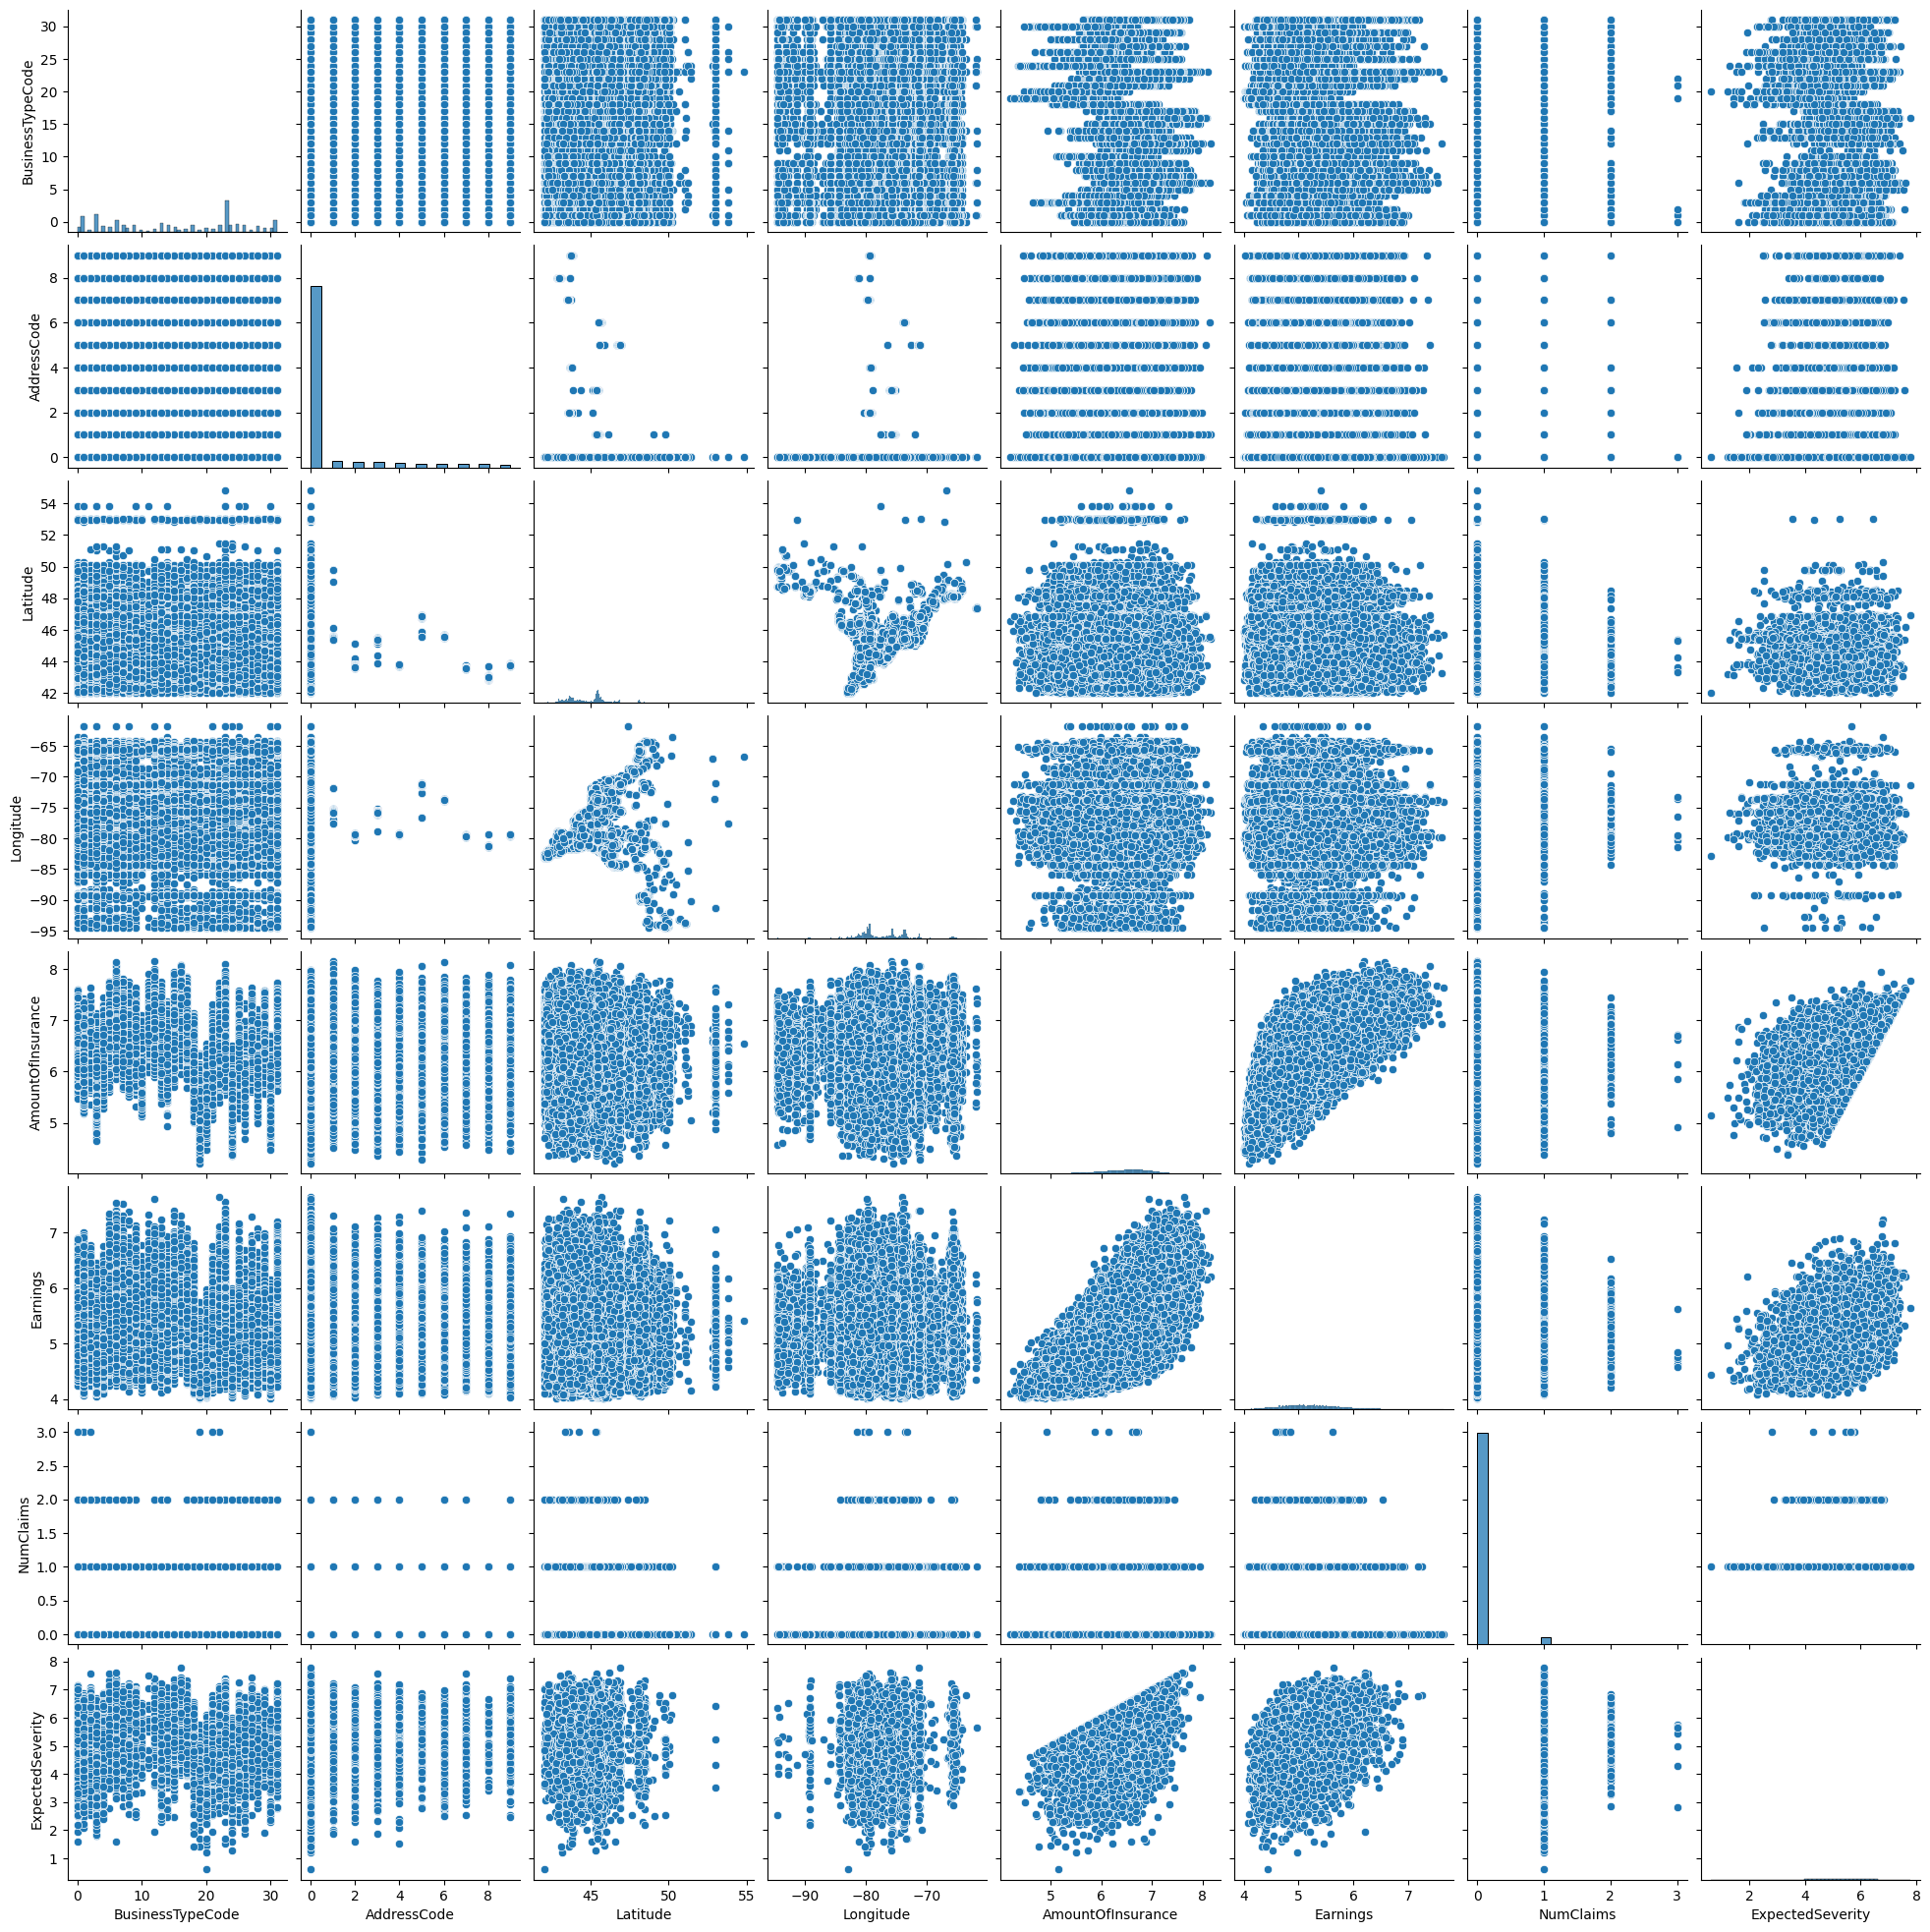

In [8]:
sns.pairplot(train_consolidated_df[["BusinessTypeCode", "AddressCode", "Latitude", "Longitude", "AmountOfInsurance", "Earnings", "NumClaims", "ExpectedSeverity"]])

### Synthetic data generation

In [9]:
# model = CTGAN(epochs=100)
# model.fit(train_consolidated_df[["BusinessTypeCode", "AddressCode", "Latitude", "Longitude", "AmountOfInsurance", "Earnings", "NumClaims", "ExpectedSeverity"]])

In [10]:
# model.save("ctgan_epoch_100.pkl")

In [11]:
# ctgan_model = CTGAN.load("ctgan_epoch_100.pkl")

In [12]:
# synthetic_data = ctgan_model.sample(num_rows=250000)
# evaluate(synthetic_data, train_consolidated_df[["BusinessTypeCode", "AddressCode", "Latitude", "Longitude", "AmountOfInsurance", "Earnings", "NumClaims", "ExpectedSeverity"]])

In [13]:
# sns.pairplot(synthetic_data[["BusinessTypeCode", "AddressCode", "Latitude", "Longitude", "AmountOfInsurance", "Earnings", "NumClaims", "ExpectedSeverity"]])

In [14]:
# # One hot encoding
# business_codes = synthetic_data.BusinessTypeCode.copy()
# synthetic_data = pd.get_dummies(synthetic_data, columns=["BusinessTypeCode"])

# # One hot encoding
# address_codes = synthetic_data.AddressCode.copy()
# synthetic_data = pd.get_dummies(synthetic_data, columns=["AddressCode"])

In [16]:
# synthetic_data

In [ ]:
# synthetic_data.columns.values.tolist()

['Latitude',
 'Longitude',
 'AmountOfInsurance',
 'Earnings',
 'NumClaims',
 'ExpectedSeverity',
 'BusinessTypeCode_0',
 'BusinessTypeCode_1',
 'BusinessTypeCode_2',
 'BusinessTypeCode_3',
 'BusinessTypeCode_4',
 'BusinessTypeCode_5',
 'BusinessTypeCode_6',
 'BusinessTypeCode_7',
 'BusinessTypeCode_8',
 'BusinessTypeCode_9',
 'BusinessTypeCode_10',
 'BusinessTypeCode_11',
 'BusinessTypeCode_12',
 'BusinessTypeCode_13',
 'BusinessTypeCode_14',
 'BusinessTypeCode_15',
 'BusinessTypeCode_16',
 'BusinessTypeCode_17',
 'BusinessTypeCode_18',
 'BusinessTypeCode_19',
 'BusinessTypeCode_20',
 'BusinessTypeCode_21',
 'BusinessTypeCode_22',
 'BusinessTypeCode_23',
 'BusinessTypeCode_24',
 'BusinessTypeCode_25',
 'BusinessTypeCode_26',
 'BusinessTypeCode_27',
 'BusinessTypeCode_28',
 'BusinessTypeCode_29',
 'BusinessTypeCode_30',
 'BusinessTypeCode_31',
 'AddressCode_0',
 'AddressCode_1',
 'AddressCode_2',
 'AddressCode_3',
 'AddressCode_4',
 'AddressCode_5',
 'AddressCode_6',
 'AddressCode_7',
 

### Training model

In [17]:
train_consolidated_df = train_consolidated_df.drop(columns=["BusinessTypeCode", "AddressCode"])
train_consolidated_df

,Latitude,Longitude,AmountOfInsurance,Earnings,BusinessTypeCode_0,BusinessTypeCode_1,BusinessTypeCode_2,BusinessTypeCode_3,BusinessTypeCode_4,BusinessTypeCode_5,...,AddressCode_2,AddressCode_3,AddressCode_4,AddressCode_5,AddressCode_6,AddressCode_7,AddressCode_8,AddressCode_9,NumClaims,ExpectedSeverity
0,43.90,-79.27,6.694067,4.682131,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,5.626450
1,43.65,-79.43,6.535532,5.147494,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1.0,4.940037
2,43.15,-80.24,6.778899,5.497168,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,5.929975
3,45.70,-73.63,6.139453,4.997212,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,4.459383
4,43.64,-79.76,6.919684,5.513429,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,5.385212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250196,45.45,-73.81,6.087456,5.680173,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
250197,45.44,-75.74,6.494359,5.575949,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
250198,43.22,-79.91,6.094247,5.347108,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
250199,46.34,-79.47,6.660191,4.882802,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN


In [18]:
train_consolidated_df.columns.values.tolist()

['Latitude',
 'Longitude',
 'AmountOfInsurance',
 'Earnings',
 'BusinessTypeCode_0',
 'BusinessTypeCode_1',
 'BusinessTypeCode_2',
 'BusinessTypeCode_3',
 'BusinessTypeCode_4',
 'BusinessTypeCode_5',
 'BusinessTypeCode_6',
 'BusinessTypeCode_7',
 'BusinessTypeCode_8',
 'BusinessTypeCode_9',
 'BusinessTypeCode_10',
 'BusinessTypeCode_11',
 'BusinessTypeCode_12',
 'BusinessTypeCode_13',
 'BusinessTypeCode_14',
 'BusinessTypeCode_15',
 'BusinessTypeCode_16',
 'BusinessTypeCode_17',
 'BusinessTypeCode_18',
 'BusinessTypeCode_19',
 'BusinessTypeCode_20',
 'BusinessTypeCode_21',
 'BusinessTypeCode_22',
 'BusinessTypeCode_23',
 'BusinessTypeCode_24',
 'BusinessTypeCode_25',
 'BusinessTypeCode_26',
 'BusinessTypeCode_27',
 'BusinessTypeCode_28',
 'BusinessTypeCode_29',
 'BusinessTypeCode_30',
 'BusinessTypeCode_31',
 'AddressCode_0',
 'AddressCode_1',
 'AddressCode_2',
 'AddressCode_3',
 'AddressCode_4',
 'AddressCode_5',
 'AddressCode_6',
 'AddressCode_7',
 'AddressCode_8',
 'AddressCode_9',


In [19]:
y1 = train_consolidated_df["NumClaims"].to_numpy()
X1 = train_consolidated_df.drop(columns=["NumClaims", "ExpectedSeverity"]).to_numpy()

# Do not assume ExpectedSeverity = 0 for businesses who have not claimed
y2 = train_consolidated_df[~train_consolidated_df.ExpectedSeverity.isnull()]["ExpectedSeverity"].to_numpy()
X2 = train_consolidated_df[~train_consolidated_df.ExpectedSeverity.isnull()].drop(columns=["NumClaims", "ExpectedSeverity"]).to_numpy()

In [20]:
# y1_valid = synthetic_data["NumClaims"].to_numpy()
# X1_valid = synthetic_data.drop(columns=["NumClaims", "ExpectedSeverity"]).to_numpy()

# # Do not assume ExpectedSeverity = 0 for businesses who have not claimed
# y2_valid = synthetic_data[~synthetic_data.ExpectedSeverity.isnull()]["ExpectedSeverity"].to_numpy()
# X2_valid = synthetic_data[~synthetic_data.ExpectedSeverity.isnull()].drop(columns=["NumClaims", "ExpectedSeverity"]).to_numpy()

### NumClaims model

In [21]:
# # Hyperparameters
# # param_grid1 = {
# #     "min_samples_split": [2, 5, 10],
# #     "n_estimators": [100, 200],
# #     "min_samples_leaf": [1, 2, 5],
# #     "max_depth": [10, 20],
# #     "ccp_alpha": [0.0001, 0.001, 0.01]
# # }
# param_grid_rf_1 = {
#     "min_samples_split": [2],
#     "n_estimators": [100],
#     "min_samples_leaf": [1],
#     "max_depth": [20],
#     "ccp_alpha": [0.0001]
# }
# model_rf_1 = RandomForestRegressor(random_state=1)
# search_rf_1= GridSearchCV(model_rf_1, param_grid=param_grid_rf_1, refit=True, cv=5, scoring="neg_mean_squared_error")
# search_rf_1.fit(X, y1)

In [22]:
# predictions = search_rf_1.predict(X)
# sns.scatterplot(x=predictions, y=y1)
# print(mean_squared_error(y1, predictions))

In [23]:
# Hyperparameter tuning
# param_grid_xgb_1 = {
#     "n_estimators": [25, 50, 75 100, 200],
#     "learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5],
#     "max_depth": [1, 2, 3, 5, 10, 15, 20],
#     "learning_rate": [0.1],
#     "subsample": [0.5, 0.6, 0.7, 0.8],
#     "colsample_bytree": [0.5, 0.6, 0.8, 0.9, 0.95, 1.0]
# }
# param_grid_xgb_1 = {
#     "n_estimators": [100],
#     "learning_rate": [0.1],
#     "max_depth": [10],
#     "subsample": [0.6],
#     "colsample_bytree": [0.95]
# }

# model_xgb_1 = XGBRegressor(random_state=1)
# search_xgb_1 = GridSearchCV(model_xgb_1, param_grid=param_grid_xgb_1, cv=5, scoring="neg_mean_squared_error")
# search_xgb_1.fit(X1, y1)
# print(np.sqrt(-search_xgb_1.best_score_))
# print(search_xgb_1.best_params_)

0.19760427312837234


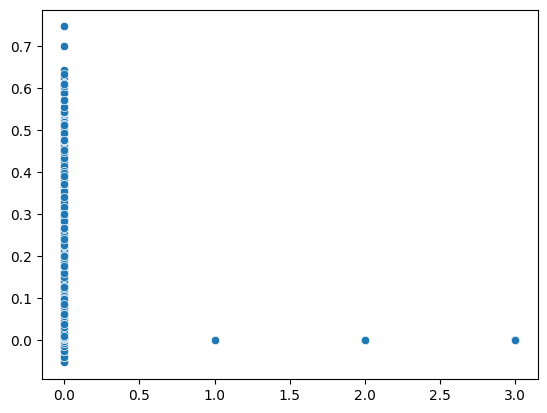

In [24]:
# 5 fold cross validation result and plot
model = XGBRegressor(random_state=1, n_estimators=100, learning_rate=0.1, max_depth=10, subsample=0.6, colsample_bytree=0.95)
predictions = cross_val_predict(model, X=X1, y=y1, cv=5)
sns.scatterplot(y=predictions, x=y1)
print(mean_squared_error(y1, predictions, squared=False))

In [25]:
# # Train on augmented data
# X = np.concatenate((X1, X1_valid), axis=0)
# y = np.concatenate((y1, y1_valid), axis=0)
# # 5 fold cross validation result and plot
# model = XGBRegressor(random_state=1, n_estimators=100, learning_rate=0.1, max_depth=10, subsample=0.6, colsample_bytree=0.95)
# predictions = cross_val_predict(model, X=X, y=y, cv=5)
# sns.scatterplot(y=predictions, x=y)
# print(mean_squared_error(y, predictions, squared=False))

In [26]:
# Train final model on whole dataset
model_xgb_1 = XGBRegressor(
    random_state=1, n_estimators=100, learning_rate=0.1, max_depth=10, subsample=0.6, colsample_bytree=0.95
)
model_xgb_1.fit(X1, y1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

### ExpectedSeverity model

In [27]:
# # Hyperparameters
# # param_grid1 = {
# #     "min_samples_split": [2, 5, 10],
# #     "n_estimators": [100, 200, 300],
# #     "min_samples_leaf": [5, 10, 20],
# #     "max_depth": [3, 5, 10],
# #     "ccp_alpha": [0.0001, 0.001, 0.01]

# # }
# param_grid_rf_2 = {
#     "min_samples_split": [2],
#     "n_estimators": [100],
#     "min_samples_leaf": [20],
#     "max_depth": [3],
#     "ccp_alpha": [0.001]
# }
# model_rf_2 = RandomForestRegressor(random_state=1)
# search_rf_2 = GridSearchCV(model_rf_2, param_grid=param_grid_rf_2, refit=True, cv=5, scoring="neg_mean_squared_error")
# search_rf_2.fit(X, y2)

In [28]:
# predictions = search_rf_2.predict(X)
# sns.scatterplot(x=predictions, y=y2)
# print(mean_squared_error(y2, predictions))

In [29]:
# Hyperparameters
# param_grid_xgb_2 = {
#     "n_estimators": [25, 50, 75 100, 200],
#     "learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5],
#     "max_depth": [1, 2, 3, 5, 10, 15, 20],
#     "learning_rate": [0.1],
#     "subsample": [0.5, 0.6, 0.7, 0.8],
#     "colsample_bytree": [0.5, 0.6, 0.8, 0.9, 0.95, 1.0]
# }
# param_grid_xgb_2 = {
#     "n_estimators": [50],
#     "learning_rate": [0.1],
#     "max_depth": [10],
#     "subsample": [0.6],
#     "colsample_bytree": [0.95]
# }

# model_xgb_2 = XGBRegressor(random_state=1)
# search_xgb_2 = GridSearchCV(model_xgb_2, param_grid=param_grid_xgb_2, refit=True, cv=5, scoring="neg_root_mean_squared_error")
# search_xgb_2.fit(X2, y2)
# print(np.sqrt(-search_xgb_2.best_score_))
# print(search_xgb_2.best_params_)

253987.65739345233


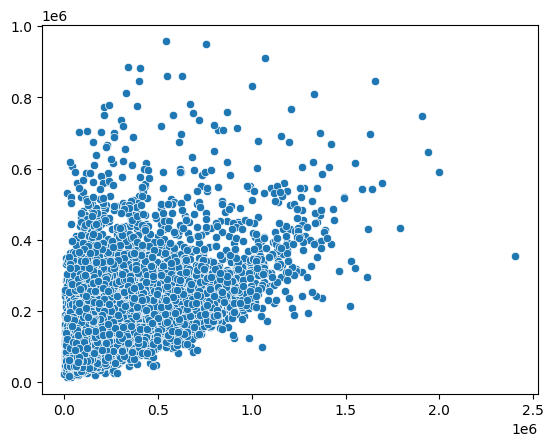

In [30]:
# 5 fold cross validation result and plot
model = XGBRegressor(random_state=1, n_estimators=50, learning_rate=0.1, max_depth=10, subsample=0.6, colsample_bytree=0.95)
predictions = cross_val_predict(model, X=X2, y=y2, cv=5)
sns.scatterplot(y=np.exp(predictions)*1000, x=np.exp(y2)*1000)
print(mean_squared_error(np.exp(y2)*1000, np.exp(predictions)*1000, squared=False))

In [31]:
# # Train on augmented data
# X = np.concatenate((X2, X2_valid))
# y = np.concatenate((y2, y2_valid))
# model = XGBRegressor(random_state=1, n_estimators=100, learning_rate=0.1, max_depth=10, subsample=0.6, colsample_bytree=0.95)
# predictions = cross_val_predict(model, X=X, y=y, cv=5)
# sns.scatterplot(y=np.exp(predictions)*1000, x=np.exp(y)*1000)
# print(mean_squared_error(np.exp(y)*1000, np.exp(predictions)*1000, squared=False))

In [32]:
# Train final model on whole dataset
model_xgb_2 = XGBRegressor(
    random_state=1, n_estimators=100, learning_rate=0.1, max_depth=10, subsample=0.6, colsample_bytree=0.95
)
model_xgb_2.fit(X2, y2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

### Inference

### Constants

In [33]:
loss_allocated_expense = 0.2
fixed_expense = 500
variable_expense = 0.4

In [34]:
test_claims_df = pd.read_csv("potential_clients.csv")
test_claims_df = test_claims_df.drop(columns=["premium_charged"])
# Sanity check: There are no new businesses in test claims data
a = set(policies_df.BusinessID)
b = set(test_claims_df.BusinessID)
print(b - a)
test_consolidated_df = test_claims_df.merge(policies_df, on="BusinessID", how="left")
test_consolidated_df

set()


,BusinessID,Latitude,Longitude,AmountOfInsurance,Earnings,BusinessTypeCode_0,BusinessTypeCode_1,BusinessTypeCode_2,BusinessTypeCode_3,BusinessTypeCode_4,...,AddressCode_1,AddressCode_2,AddressCode_3,AddressCode_4,AddressCode_5,AddressCode_6,AddressCode_7,AddressCode_8,AddressCode_9,AddressCode
0,00003A17,43.54,-80.26,6.635815,4.770685,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00003A35,43.82,-79.27,6.220789,5.170484,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,4
2,0006A149,43.94,-79.97,6.511151,5.817111,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0000A221,45.38,-75.81,7.086320,5.429346,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0001A225,42.86,-80.70,6.271933,5.347108,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,3A249510,43.53,-79.84,5.625461,4.382027,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2717,6A249645,44.75,-79.71,5.938591,4.682131,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2718,1A249679,45.48,-73.45,6.107691,4.812184,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2719,8A249755,43.89,-81.29,6.226734,4.624973,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# # Predict GeoClusterCode for test data
# # DBSCAN can generate non-convex cluster and it cannot predict unseen points, however, I take motivation from below link to find nearest centroid for cluster membership prediction
# # https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
# # NOTE: I know this is NOT ideal but I am thinking this as an approximation
# cluster_to_idx = defaultdict(list)
# for idx, cluster in enumerate(db.labels_):
#     cluster_to_idx[cluster].append(idx)
# cluster_centroids = np.zeros((len(cluster_to_idx), 2))
# for cluster in range(len(cluster_to_idx)):
#     cluster_centroids[cluster] = coords[cluster_to_idx[cluster]].mean(axis=0)
# cluster_centroids

# test_coords = np.radians(test_consolidated_df[["Latitude", "Longitude"]].to_numpy())
# test_consolidated_df["GeoClusterCode"] = np.argmin(haversine_distances(test_coords, cluster_centroids), axis=1)

# # One hot encoding of geo cluster
# geocluster_codes = test_consolidated_df.GeoClusterCode.copy()
# test_consolidated_df = pd.get_dummies(test_consolidated_df, columns=["GeoClusterCode"])
# test_consolidated_df["GeoClusterCode"] = geocluster_codes

# # Add geo clusters which were not predicted
# for cluster in (set(range(len(cluster_to_idx))) - set(geocluster_codes)):
#     test_consolidated_df[f"GeoClusterCode_{cluster}"] = 0

# sns.scatterplot(test_consolidated_df, x="Longitude", y="Latitude", hue="GeoClusterCode", palette="turbo")

In [36]:
test_consolidated_df = test_consolidated_df.drop(columns=["BusinessID", "BusinessTypeCode", "AddressCode"])
test_consolidated_df

,Latitude,Longitude,AmountOfInsurance,Earnings,BusinessTypeCode_0,BusinessTypeCode_1,BusinessTypeCode_2,BusinessTypeCode_3,BusinessTypeCode_4,BusinessTypeCode_5,...,AddressCode_0,AddressCode_1,AddressCode_2,AddressCode_3,AddressCode_4,AddressCode_5,AddressCode_6,AddressCode_7,AddressCode_8,AddressCode_9
0,43.54,-80.26,6.635815,4.770685,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,43.82,-79.27,6.220789,5.170484,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,43.94,-79.97,6.511151,5.817111,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,45.38,-75.81,7.086320,5.429346,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,42.86,-80.70,6.271933,5.347108,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,43.53,-79.84,5.625461,4.382027,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2717,44.75,-79.71,5.938591,4.682131,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2718,45.48,-73.45,6.107691,4.812184,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2719,43.89,-81.29,6.226734,4.624973,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [37]:
test_consolidated_df.columns.values.tolist()

['Latitude',
 'Longitude',
 'AmountOfInsurance',
 'Earnings',
 'BusinessTypeCode_0',
 'BusinessTypeCode_1',
 'BusinessTypeCode_2',
 'BusinessTypeCode_3',
 'BusinessTypeCode_4',
 'BusinessTypeCode_5',
 'BusinessTypeCode_6',
 'BusinessTypeCode_7',
 'BusinessTypeCode_8',
 'BusinessTypeCode_9',
 'BusinessTypeCode_10',
 'BusinessTypeCode_11',
 'BusinessTypeCode_12',
 'BusinessTypeCode_13',
 'BusinessTypeCode_14',
 'BusinessTypeCode_15',
 'BusinessTypeCode_16',
 'BusinessTypeCode_17',
 'BusinessTypeCode_18',
 'BusinessTypeCode_19',
 'BusinessTypeCode_20',
 'BusinessTypeCode_21',
 'BusinessTypeCode_22',
 'BusinessTypeCode_23',
 'BusinessTypeCode_24',
 'BusinessTypeCode_25',
 'BusinessTypeCode_26',
 'BusinessTypeCode_27',
 'BusinessTypeCode_28',
 'BusinessTypeCode_29',
 'BusinessTypeCode_30',
 'BusinessTypeCode_31',
 'AddressCode_0',
 'AddressCode_1',
 'AddressCode_2',
 'AddressCode_3',
 'AddressCode_4',
 'AddressCode_5',
 'AddressCode_6',
 'AddressCode_7',
 'AddressCode_8',
 'AddressCode_9']

In [38]:
def calculate_premium(profit_loading, model1, model2):
    # Profit loading can vary from 0 to 0.6, default is 0.3
    X = test_consolidated_df.to_numpy()
    num_claims = model1.predict(X)
    # Number of claims cannot be zero
    num_claims = np.abs(num_claims)
    expected_severity = model2.predict(X)
    # Inverse transform
    expected_severity = np.exp(expected_severity) * 1000
    premium = (num_claims * expected_severity * (1 - loss_allocated_expense) + fixed_expense) / (1 - variable_expense - profit_loading)
    premium = premium.round(2)
    return premium

### Create output

In [39]:
# model1 -> frequency
# model2 -> severity
test_claims_df["premium_charged"] = calculate_premium(profit_loading=0.3, model1=model_xgb_1, model2=model_xgb_2)
test_claims_df.to_csv("potential_clients_prediction.csv", index=False)

In [40]:
test_claims_df.describe()

,premium_charged
count,2721.000000
mean,20415.855469
std,21445.583984
min,1694.859985
25%,9528.839844
50%,15212.769531
75%,23503.000000
max,270875.406250


<AxesSubplot: xlabel='premium_charged', ylabel='Count'>

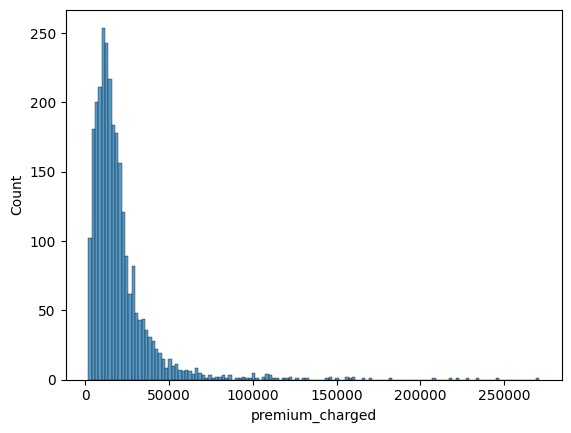

In [41]:
sns.histplot(test_claims_df.premium_charged)

<AxesSubplot: xlabel='ClaimAmount', ylabel='Count'>

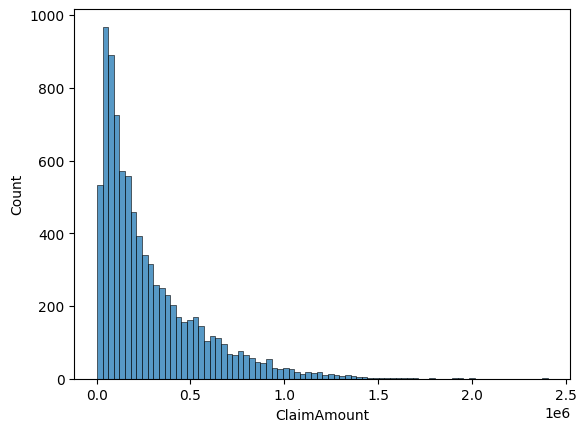

In [42]:
sns.histplot(claims_df.ClaimAmount)